# Лабораторная работа № 4
## Работа с алгоритмом Random Forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import re

# Настройки для графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Загрузка и подготовка данных

Для исследования алгоритма случайного леса будем использовать те же наборы данных, что и в предыдущих лабораторных работах:
- Для классификации: датасет детекции дыма IoT-сенсоров
- Для регрессии: датасет цен подержанных автомобилей

In [3]:
# Загрузка данных для классификации
clf_data = pd.read_csv("datasets/smoke_detection_iot.csv")
clf_X = clf_data.drop(columns=["Fire Alarm", "Unnamed: 0", "CNT"])
clf_y = clf_data["Fire Alarm"]

print("Данные классификации:")
print(f"Размер датасета: {clf_data.shape}")
print(f"Количество признаков: {clf_X.shape[1]}")
print(f"Распределение классов:\n{clf_y.value_counts()}")

# Загрузка данных для регрессии
reg_data = pd.read_csv("datasets/used_cars.csv")

# Предобработка данных регрессии
def clean_mileage(mileage_str):
    """Извлечение числового значения пробега из строки"""
    if pd.isna(mileage_str):
        return np.nan
    cleaned = re.sub(r'[^\d]', '', str(mileage_str))
    return float(cleaned) if cleaned else np.nan

reg_data['mileage_numeric'] = reg_data['milage'].apply(clean_mileage)

# Создание признака возраста автомобиля
current_year = 2023
reg_data['vehicle_age'] = current_year - reg_data['model_year']

# Обработка целевой переменной
prices_cleaned = (
    reg_data["price"]
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# Удаление экстремальных выбросов
price_threshold = prices_cleaned.quantile(0.995)
mask = prices_cleaned <= price_threshold
reg_data = reg_data[mask]
prices_cleaned = prices_cleaned[mask]

# Обработка пропусков
reg_data['fuel_type'] = reg_data['fuel_type'].fillna('Unknown')
reg_data['accident'] = reg_data['accident'].fillna('Unknown')

# Удаление бесполезных столбцов
reg_data = reg_data.drop(columns=['price', 'clean_title', 'milage'], errors='ignore')

# Кодирование категориальных признаков
reg_X = pd.get_dummies(reg_data, drop_first=True)
reg_y = prices_cleaned

print("\nДанные регрессии:")
print(f"Размер датасета: {reg_X.shape}")
print(f"Количество признаков после обработки: {reg_X.shape[1]}")
print(f"Диапазон цен: ${reg_y.min():.0f} - ${reg_y.max():.0f}")

Данные классификации:
Размер датасета: (62630, 16)
Количество признаков: 13
Распределение классов:
Fire Alarm
1    44757
0    17873
Name: count, dtype: int64

Данные регрессии:
Размер датасета: (3988, 3607)
Количество признаков после обработки: 3607
Диапазон цен: $2000 - $359991


## Создание бейзлайна Random Forest

### Разделение данных на обучающую и тестовую выборки

In [4]:
# Разделение данных для классификации
clf_X_train, clf_X_test, clf_y_train, clf_y_test = train_test_split(
    clf_X, clf_y,
    test_size=0.2,
    random_state=42,
    stratify=clf_y
)

# Разделение данных для регрессии
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(
    reg_X, reg_y,
    test_size=0.2,
    random_state=42
)

print("Размеры данных:")
print(f"Классификация - train: {clf_X_train.shape}, test: {clf_X_test.shape}")
print(f"Регрессия - train: {reg_X_train.shape}, test: {reg_X_test.shape}")

# Нормализация данных
clf_scaler = StandardScaler()
clf_X_train_scaled = clf_scaler.fit_transform(clf_X_train)
clf_X_test_scaled = clf_scaler.transform(clf_X_test)

reg_scaler = StandardScaler()
reg_X_train_scaled = reg_scaler.fit_transform(reg_X_train)
reg_X_test_scaled = reg_scaler.transform(reg_X_test)

Размеры данных:
Классификация - train: (50104, 13), test: (12526, 13)
Регрессия - train: (3190, 3607), test: (798, 3607)


### Обучение базовых моделей Random Forest

Для демонстрации эффективности оптимизации гиперпараметров создадим намеренно слабые базовые модели с ограниченными параметрами.

In [21]:
# Обучение базовой модели Random Forest для классификации
# Используем заведомо плохие параметры для демонстрации эффекта оптимизации
baseline_clf = RandomForestClassifier(
    n_estimators=10,        # Очень мало деревьев
    max_depth=3,            # Очень маленькая глубина
    min_samples_split=20,   # Большое минимальное количество для разбиения
    min_samples_leaf=10,    # Большое минимальное количество в листе
    max_features=1,         # Используем только 1 признак
    random_state=42, 
    n_jobs=-1
)
baseline_clf.fit(clf_X_train_scaled, clf_y_train)

# Предсказания для классификации
clf_y_pred = baseline_clf.predict(clf_X_test_scaled)
clf_y_proba = baseline_clf.predict_proba(clf_X_test_scaled)[:, 1]

# Метрики для классификации
clf_accuracy = accuracy_score(clf_y_test, clf_y_pred)
clf_precision = precision_score(clf_y_test, clf_y_pred)
clf_recall = recall_score(clf_y_test, clf_y_pred)
clf_f1 = f1_score(clf_y_test, clf_y_pred)
clf_roc_auc = roc_auc_score(clf_y_test, clf_y_proba)
clf_cm = confusion_matrix(clf_y_test, clf_y_pred)

print("Результаты baseline Random Forest для классификации:")
print("=" * 55)
print(f"Accuracy:  {clf_accuracy:.4f}")
print(f"Precision: {clf_precision:.4f}")
print(f"Recall:    {clf_recall:.4f}")
print(f"F1-score:  {clf_f1:.4f}")
print(f"ROC-AUC:   {clf_roc_auc:.4f}")
print("\nMatrица ошибок:")
print(clf_cm)

Результаты baseline Random Forest для классификации:
Accuracy:  0.9769
Precision: 0.9780
Recall:    0.9899
F1-score:  0.9840
ROC-AUC:   0.9970

Matrица ошибок:
[[3376  199]
 [  90 8861]]


In [22]:
# Обучение базовой модели Random Forest для регрессии
# Используем заведомо плохие параметры для демонстрации эффекта оптимизации
baseline_reg = RandomForestRegressor(
    n_estimators=5,         # Очень мало деревьев
    max_depth=2,            # Очень маленькая глубина
    min_samples_split=50,   # Большое минимальное количество для разбиения
    min_samples_leaf=20,    # Большое минимальное количество в листе
    max_features=1,         # Используем только 1 признак
    random_state=42, 
    n_jobs=-1
)
baseline_reg.fit(reg_X_train_scaled, reg_y_train)

# Предсказания для регрессии
reg_y_pred = baseline_reg.predict(reg_X_test_scaled)

# Метрики для регрессии
reg_mae = mean_absolute_error(reg_y_test, reg_y_pred)
reg_mse = mean_squared_error(reg_y_test, reg_y_pred)
reg_rmse = np.sqrt(reg_mse)
reg_r2 = r2_score(reg_y_test, reg_y_pred)

print("\nРезультаты baseline Random Forest для регрессии:")
print("=" * 50)
print(f"MAE:  {reg_mae:.2f}")
print(f"MSE:  {reg_mse:.2f}")
print(f"RMSE: {reg_rmse:.2f}")
print(f"R²:   {reg_r2:.4f}")

# Дополнительная информация о моделях
print(f"\nДополнительная информация:")
print(f"Количество деревьев в модели классификации: {baseline_clf.n_estimators}")
print(f"Количество деревьев в модели регрессии: {baseline_reg.n_estimators}")
print(f"Максимальная глубина деревьев: {baseline_clf.max_depth}")
print(f"Минимальное количество объектов для разбиения: {baseline_clf.min_samples_split}")
print(f"Максимальное количество признаков: {baseline_clf.max_features}")
print(f"Важность признаков (топ-5) для классификации:")
feature_importance_clf = pd.DataFrame({
    'feature': clf_X.columns,
    'importance': baseline_clf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_clf.head())


Результаты baseline Random Forest для регрессии:
MAE:  24862.16
MSE:  1628941137.52
RMSE: 40360.14
R²:   -0.0011

Дополнительная информация:
Количество деревьев в модели классификации: 10
Количество деревьев в модели регрессии: 5
Максимальная глубина деревьев: 3
Минимальное количество объектов для разбиения: 20
Максимальное количество признаков: 1
Важность признаков (топ-5) для классификации:
         feature  importance
3      TVOC[ppb]    0.184532
0            UTC    0.172159
2    Humidity[%]    0.138044
6    Raw Ethanol    0.130742
7  Pressure[hPa]    0.092833


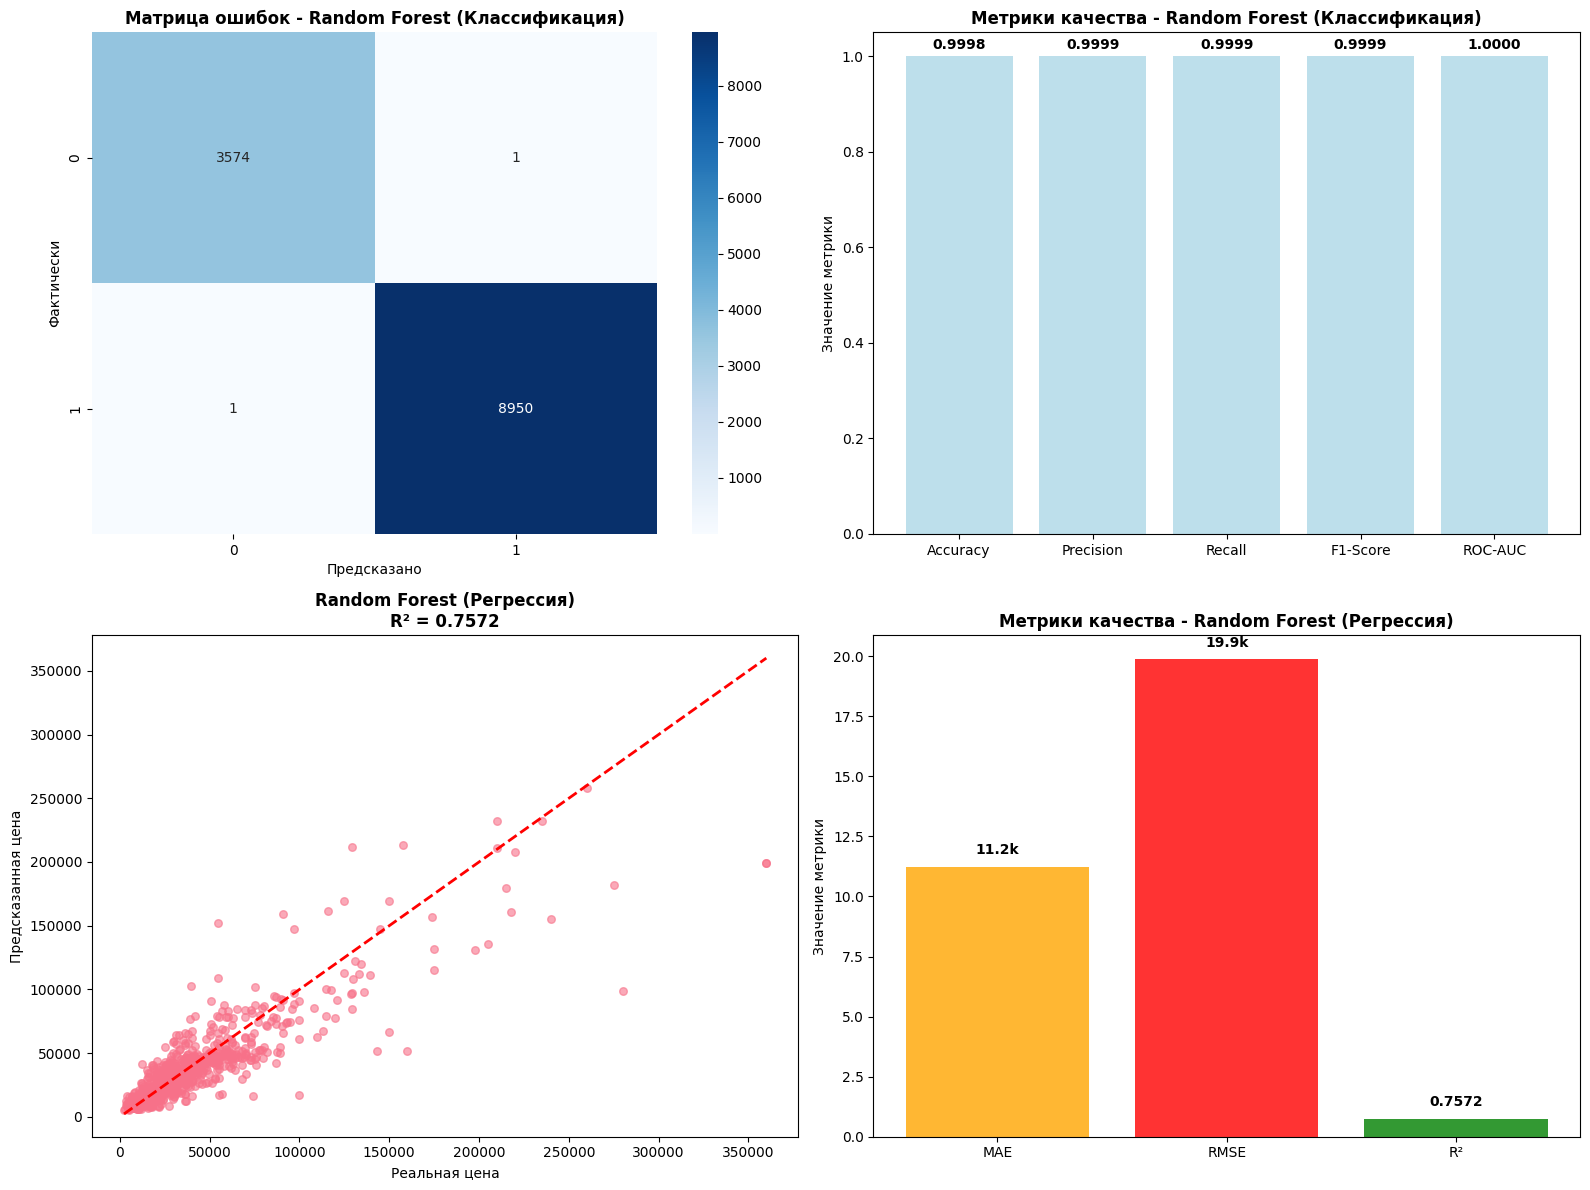

In [7]:
# Визуализация результатов baseline моделей
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Матрица ошибок для классификации
sns.heatmap(clf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Матрица ошибок - Random Forest (Классификация)', fontweight='bold')
axes[0,0].set_xlabel('Предсказано')
axes[0,0].set_ylabel('Фактически')

# Метрики классификации
clf_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
clf_metrics_values = [clf_accuracy, clf_precision, clf_recall, clf_f1, clf_roc_auc]

bars1 = axes[0,1].bar(clf_metrics_names, clf_metrics_values, alpha=0.8, color='lightblue')
axes[0,1].set_title('Метрики качества - Random Forest (Классификация)', fontweight='bold')
axes[0,1].set_ylabel('Значение метрики')
axes[0,1].set_ylim(0, 1.05)

for bar, value in zip(bars1, clf_metrics_values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Реальные vs Предсказанные для регрессии
axes[1,0].scatter(reg_y_test, reg_y_pred, alpha=0.6, s=30)
axes[1,0].plot([reg_y_test.min(), reg_y_test.max()], [reg_y_test.min(), reg_y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Реальная цена')
axes[1,0].set_ylabel('Предсказанная цена')
axes[1,0].set_title(f'Random Forest (Регрессия)\nR² = {reg_r2:.4f}', fontweight='bold')

# Метрики регрессии
reg_metrics_names = ['MAE', 'RMSE', 'R²']
reg_metrics_values = [reg_mae/1000, reg_rmse/1000, reg_r2]  # MAE и RMSE в тысячах

bars2 = axes[1,1].bar(reg_metrics_names, reg_metrics_values, alpha=0.8, 
                      color=['orange', 'red', 'green'])
axes[1,1].set_title('Метрики качества - Random Forest (Регрессия)', fontweight='bold')
axes[1,1].set_ylabel('Значение метрики')

for i, (bar, value) in enumerate(zip(bars2, reg_metrics_values)):
    if i < 2:  # MAE и RMSE
        axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(reg_metrics_values)*0.02, 
                       f'{value:.1f}k', ha='center', va='bottom', fontweight='bold')
    else:  # R²
        axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(reg_metrics_values)*0.02, 
                       f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Анализ важности признаков

Random Forest предоставляет информацию о важности признаков, что полезно для понимания модели и feature engineering.

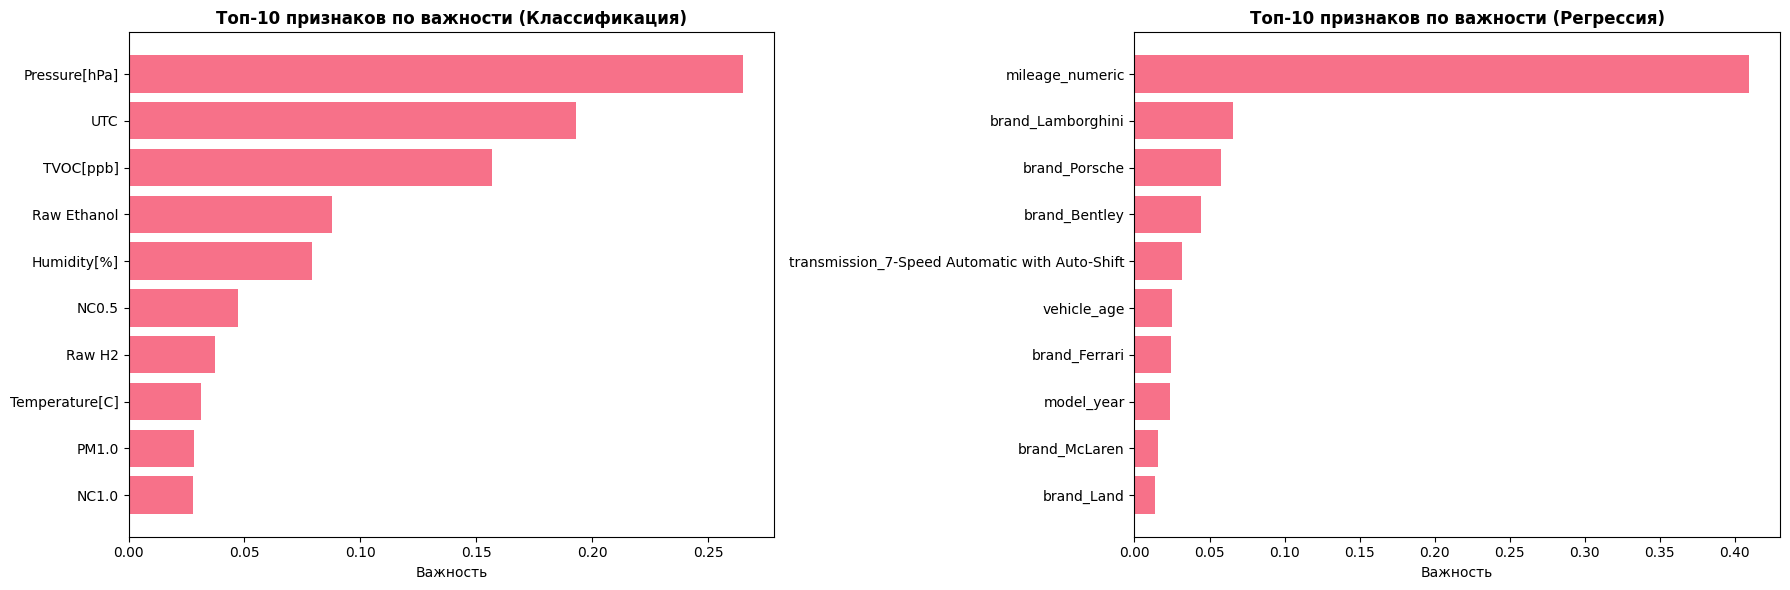

Самые важные признаки для классификации:
      feature  importance
Pressure[hPa]    0.265219
          UTC    0.193205
    TVOC[ppb]    0.156957
  Raw Ethanol    0.087682
  Humidity[%]    0.079197

Самые важные признаки для регрессии:
                                       feature  importance
                               mileage_numeric    0.409581
                             brand_Lamborghini    0.065691
                                 brand_Porsche    0.057762
                                 brand_Bentley    0.044490
transmission_7-Speed Automatic with Auto-Shift    0.031565


In [8]:
# Анализ важности признаков
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Важность признаков для классификации
feature_importance_clf = pd.DataFrame({
    'feature': clf_X.columns,
    'importance': baseline_clf.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[0].barh(feature_importance_clf['feature'], feature_importance_clf['importance'])
axes[0].set_title('Топ-10 признаков по важности (Классификация)', fontweight='bold')
axes[0].set_xlabel('Важность')

# Важность признаков для регрессии  
feature_importance_reg = pd.DataFrame({
    'feature': reg_X.columns,
    'importance': baseline_reg.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1].barh(feature_importance_reg['feature'], feature_importance_reg['importance'])
axes[1].set_title('Топ-10 признаков по важности (Регрессия)', fontweight='bold')
axes[1].set_xlabel('Важность')

plt.tight_layout()
plt.show()

print("Самые важные признаки для классификации:")
print(feature_importance_clf.sort_values('importance', ascending=False).head().to_string(index=False))

print("\nСамые важные признаки для регрессии:")
print(feature_importance_reg.sort_values('importance', ascending=False).head().to_string(index=False))

## Улучшение бейзлайна

### Формулировка гипотез

Для улучшения качества моделей Random Forest сформулируем следующие гипотезы:

**Классификация (детекция дыма):**
1. Подбор оптимального количества деревьев (n_estimators) улучшит качество модели
2. Настройка максимальной глубины деревьев (max_depth) предотвратит переобучение
3. Увеличение минимального количества объектов в листе (min_samples_leaf) стабилизирует модель
4. Настройка максимального количества признаков для разбиения (max_features) улучшит обобщающую способность

**Регрессия (цены автомобилей):**
1. Увеличение количества деревьев снизит дисперсию предсказаний
2. Ограничение глубины деревьев уменьшит переобучение на шумных данных
3. Настройка min_samples_split предотвратит создание слишком специфичных правил
4. Использование bootstrap=False может улучшить качество на данном размере выборки

### Подбор гиперпараметров

In [10]:
# Подбор гиперпараметров для классификации
print("Подбор гиперпараметров для Random Forest (классификация)")
print("=" * 60)

# Определение сетки гиперпараметров для классификации
param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [15, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Настройка кросс-валидации
cv_clf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создание объекта GridSearchCV
grid_search_clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_clf,
    cv=cv_clf,
    scoring='f1',  # Используем F1-score как основную метрику
    n_jobs=-1,
    verbose=1
)

print("Выполнение поиска оптимальных гиперпараметров...")
grid_search_clf.fit(clf_X_train_scaled, clf_y_train)

print(f"Лучшие параметры: {grid_search_clf.best_params_}")
print(f"Лучший результат кросс-валидации (F1): {grid_search_clf.best_score_:.4f}")

# Сохранение лучшей модели классификации
best_clf = grid_search_clf.best_estimator_

Подбор гиперпараметров для Random Forest (классификация)
Выполнение поиска оптимальных гиперпараметров...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучший результат кросс-валидации (F1): 0.9999
Лучшие параметры: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучший результат кросс-валидации (F1): 0.9999


In [11]:
# Подбор гиперпараметров для регрессии
print("\nПодбор гиперпараметров для Random Forest (регрессия)")
print("=" * 55)

# Определение сетки гиперпараметров для регрессии
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [15, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Настройка кросс-валидации
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

# Создание объекта GridSearchCV
grid_search_reg = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_reg,
    cv=cv_reg,
    scoring='r2',  # Используем R² как основную метрику
    n_jobs=-1,
    verbose=1
)

print("Выполнение поиска оптимальных гиперпараметров...")
grid_search_reg.fit(reg_X_train_scaled, reg_y_train)

print(f"Лучшие параметры: {grid_search_reg.best_params_}")
print(f"Лучший результат кросс-валидации (R²): {grid_search_reg.best_score_:.4f}")

# Сохранение лучшей модели регрессии
best_reg = grid_search_reg.best_estimator_


Подбор гиперпараметров для Random Forest (регрессия)
Выполнение поиска оптимальных гиперпараметров...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучший результат кросс-валидации (R²): 0.6707
Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Лучший результат кросс-валидации (R²): 0.6707


### Оценка улучшенных моделей

In [23]:
# Оценка улучшенной модели классификации
print("Результаты улучшенной модели Random Forest (классификация)")
print("=" * 60)

# Предсказания улучшенной модели классификации
clf_y_pred_improved = best_clf.predict(clf_X_test_scaled)
clf_y_proba_improved = best_clf.predict_proba(clf_X_test_scaled)[:, 1]

# Метрики улучшенной модели классификации
clf_accuracy_improved = accuracy_score(clf_y_test, clf_y_pred_improved)
clf_precision_improved = precision_score(clf_y_test, clf_y_pred_improved)
clf_recall_improved = recall_score(clf_y_test, clf_y_pred_improved)
clf_f1_improved = f1_score(clf_y_test, clf_y_pred_improved)
clf_roc_auc_improved = roc_auc_score(clf_y_test, clf_y_proba_improved)
clf_cm_improved = confusion_matrix(clf_y_test, clf_y_pred_improved)

print(f"Accuracy:  {clf_accuracy_improved:.4f}")
print(f"Precision: {clf_precision_improved:.4f}")
print(f"Recall:    {clf_recall_improved:.4f}")
print(f"F1-score:  {clf_f1_improved:.4f}")
print(f"ROC-AUC:   {clf_roc_auc_improved:.4f}")
print("\nМатрица ошибок:")
print(clf_cm_improved)

Результаты улучшенной модели Random Forest (классификация)
Accuracy:  0.9998
Precision: 0.9999
Recall:    0.9999
F1-score:  0.9999
ROC-AUC:   1.0000

Матрица ошибок:
[[3574    1]
 [   1 8950]]


In [24]:
# Оценка улучшенной модели регрессии
print("\nРезультаты улучшенной модели Random Forest (регрессия)")
print("=" * 55)

# Предсказания улучшенной модели регрессии
reg_y_pred_improved = best_reg.predict(reg_X_test_scaled)

# Метрики улучшенной модели регрессии
reg_mae_improved = mean_absolute_error(reg_y_test, reg_y_pred_improved)
reg_mse_improved = mean_squared_error(reg_y_test, reg_y_pred_improved)
reg_rmse_improved = np.sqrt(reg_mse_improved)
reg_r2_improved = r2_score(reg_y_test, reg_y_pred_improved)

print(f"MAE:  {reg_mae_improved:.2f}")
print(f"MSE:  {reg_mse_improved:.2f}")
print(f"RMSE: {reg_rmse_improved:.2f}")
print(f"R²:   {reg_r2_improved:.4f}")

# Сравнение с baseline
print(f"\nСравнение с baseline:")
print(f"Классификация:")
print(f"  F1-score: {clf_f1:.4f} → {clf_f1_improved:.4f} (изменение: {clf_f1_improved - clf_f1:+.4f})")
print(f"  Accuracy: {clf_accuracy:.4f} → {clf_accuracy_improved:.4f} (изменение: {clf_accuracy_improved - clf_accuracy:+.4f})")

print(f"Регрессия:")
print(f"  R²:   {reg_r2:.4f} → {reg_r2_improved:.4f} (изменение: {reg_r2_improved - reg_r2:+.4f})")
print(f"  RMSE: {reg_rmse:.2f} → {reg_rmse_improved:.2f} (изменение: {reg_rmse_improved - reg_rmse:+.2f})")


Результаты улучшенной модели Random Forest (регрессия)
MAE:  10643.21
MSE:  395428913.26
RMSE: 19885.39
R²:   0.7570

Сравнение с baseline:
Классификация:
  F1-score: 0.9840 → 0.9999 (изменение: +0.0159)
  Accuracy: 0.9769 → 0.9998 (изменение: +0.0229)
Регрессия:
  R²:   -0.0011 → 0.7570 (изменение: +0.7581)
  RMSE: 40360.14 → 19885.39 (изменение: -20474.75)


### Сравнительный анализ результатов

In [25]:
# Сравнительная таблица результатов
comparison_clf = pd.DataFrame({
    'Baseline RF': [clf_accuracy, clf_precision, clf_recall, clf_f1, clf_roc_auc],
    'Improved RF': [clf_accuracy_improved, clf_precision_improved, clf_recall_improved, 
                    clf_f1_improved, clf_roc_auc_improved]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

comparison_reg = pd.DataFrame({
    'Baseline RF': [reg_mae, reg_rmse, reg_r2],
    'Improved RF': [reg_mae_improved, reg_rmse_improved, reg_r2_improved]
}, index=['MAE', 'RMSE', 'R²'])

print("Сравнение результатов классификации:")
print("=" * 40)
print(comparison_clf.round(4))

improvement_clf = comparison_clf['Improved RF'] - comparison_clf['Baseline RF']
print(f"\nИзменения (Improved - Baseline):")
print(improvement_clf.round(4))

print("\n\nСравнение результатов регрессии:")
print("=" * 35)
print(comparison_reg.round(4))

improvement_reg = comparison_reg['Improved RF'] - comparison_reg['Baseline RF']
print(f"\nИзменения (Improved - Baseline):")
print(improvement_reg.round(4))

Сравнение результатов классификации:
           Baseline RF  Improved RF
Accuracy        0.9769       0.9998
Precision       0.9780       0.9999
Recall          0.9899       0.9999
F1-Score        0.9840       0.9999
ROC-AUC         0.9970       1.0000

Изменения (Improved - Baseline):
Accuracy     0.0229
Precision    0.0219
Recall       0.0099
F1-Score     0.0159
ROC-AUC      0.0030
dtype: float64


Сравнение результатов регрессии:
      Baseline RF  Improved RF
MAE    24862.1561   10643.2069
RMSE   40360.1429   19885.3945
R²        -0.0011       0.7570

Изменения (Improved - Baseline):
MAE    -14218.9492
RMSE   -20474.7485
R²          0.7581
dtype: float64


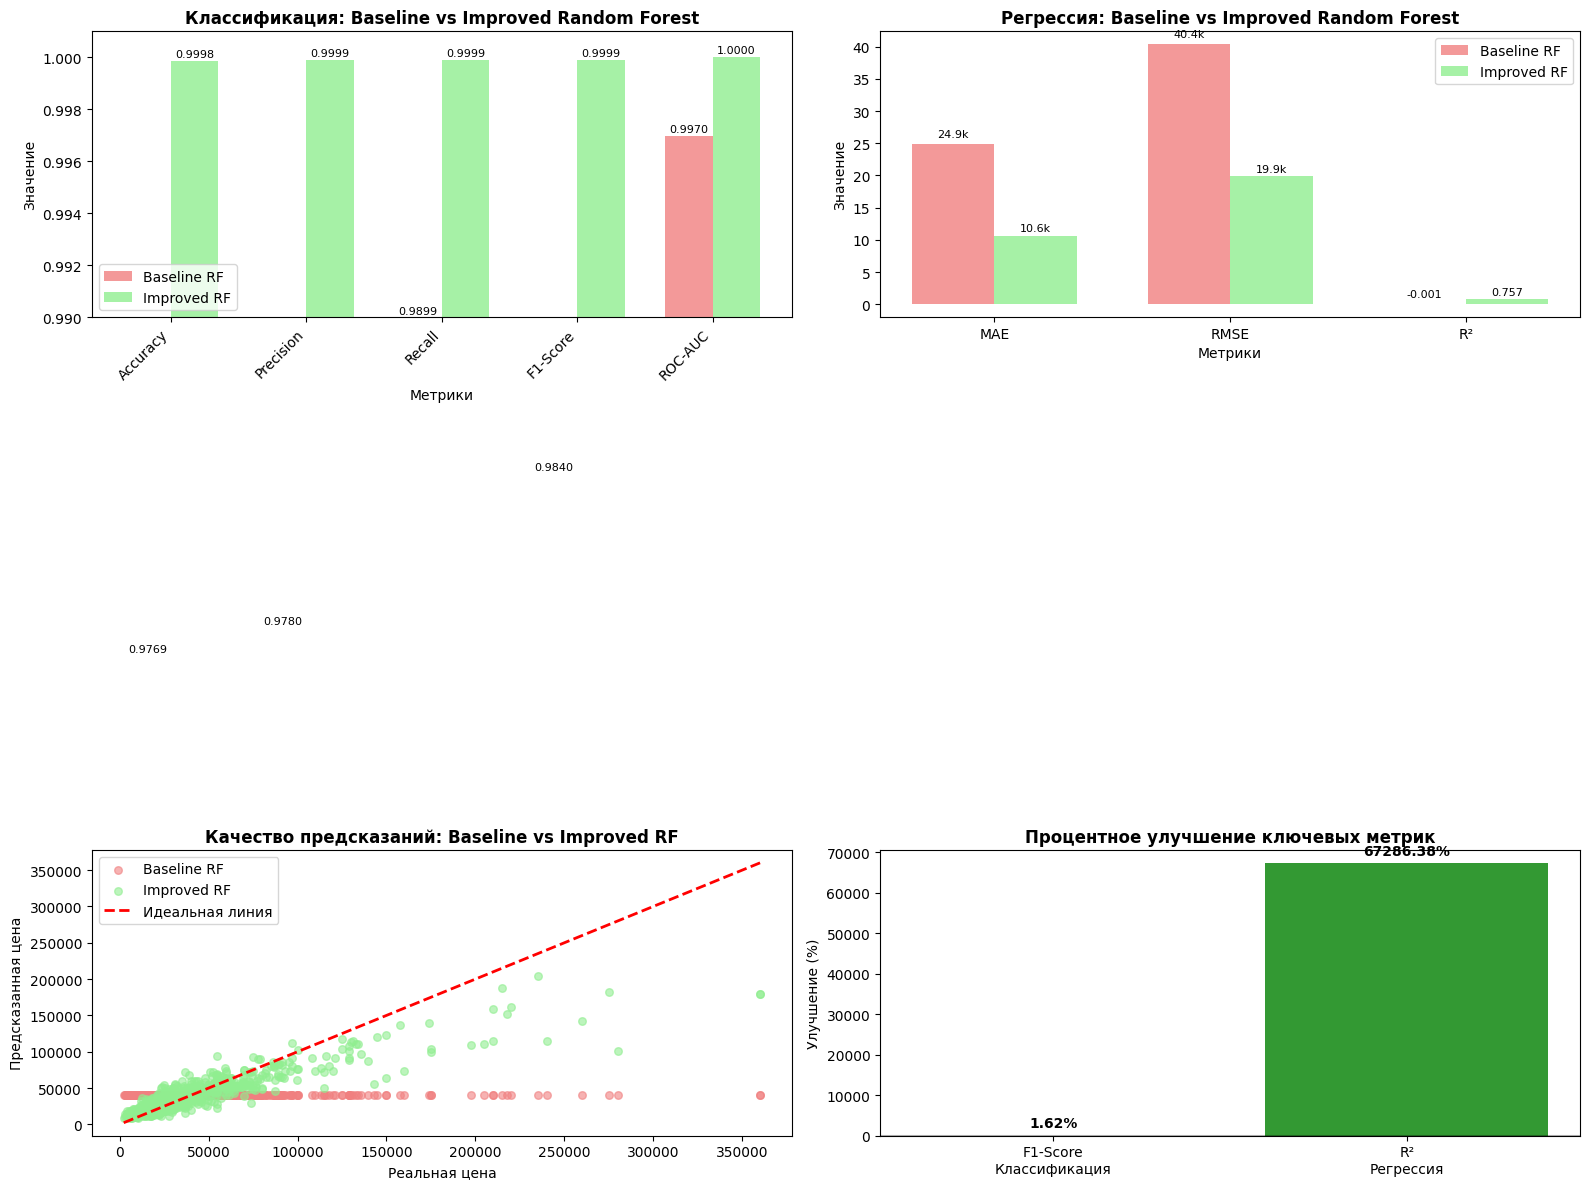

In [26]:
# Визуализация сравнения результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Сравнение метрик классификации
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
baseline_values = [clf_accuracy, clf_precision, clf_recall, clf_f1, clf_roc_auc]
improved_values = [clf_accuracy_improved, clf_precision_improved, clf_recall_improved, 
                   clf_f1_improved, clf_roc_auc_improved]

x_pos = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0,0].bar(x_pos - width/2, baseline_values, width, label='Baseline RF', alpha=0.8, color='lightcoral')
bars2 = axes[0,0].bar(x_pos + width/2, improved_values, width, label='Improved RF', alpha=0.8, color='lightgreen')

axes[0,0].set_xlabel('Метрики')
axes[0,0].set_ylabel('Значение')
axes[0,0].set_title('Классификация: Baseline vs Improved Random Forest', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(metrics_names, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].set_ylim(0.99, 1.001)

# Добавляем значения на столбцы
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.0001, 
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# Сравнение метрик регрессии
reg_metrics_names = ['MAE', 'RMSE', 'R²']
reg_baseline_values = [reg_mae/1000, reg_rmse/1000, reg_r2]
reg_improved_values = [reg_mae_improved/1000, reg_rmse_improved/1000, reg_r2_improved]

x_pos_reg = np.arange(len(reg_metrics_names))

bars3 = axes[0,1].bar(x_pos_reg - width/2, reg_baseline_values, width, label='Baseline RF', 
                      alpha=0.8, color='lightcoral')
bars4 = axes[0,1].bar(x_pos_reg + width/2, reg_improved_values, width, label='Improved RF', 
                      alpha=0.8, color='lightgreen')

axes[0,1].set_xlabel('Метрики')
axes[0,1].set_ylabel('Значение')
axes[0,1].set_title('Регрессия: Baseline vs Improved Random Forest', fontweight='bold')
axes[0,1].set_xticks(x_pos_reg)
axes[0,1].set_xticklabels(reg_metrics_names)
axes[0,1].legend()

# Добавляем значения на столбцы для регрессии
for i, bar in enumerate(bars3):
    height = bar.get_height()
    if i < 2:  # MAE, RMSE
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(reg_baseline_values)*0.02, 
                       f'{height:.1f}k', ha='center', va='bottom', fontsize=8)
    else:  # R²
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(reg_baseline_values)*0.02, 
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    if i < 2:  # MAE, RMSE
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(reg_improved_values)*0.02, 
                       f'{height:.1f}k', ha='center', va='bottom', fontsize=8)
    else:  # R²
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + max(reg_improved_values)*0.02, 
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Сравнение предсказаний регрессии
axes[1,0].scatter(reg_y_test, reg_y_pred, alpha=0.6, s=30, label='Baseline RF', color='lightcoral')
axes[1,0].scatter(reg_y_test, reg_y_pred_improved, alpha=0.6, s=30, label='Improved RF', color='lightgreen')
axes[1,0].plot([reg_y_test.min(), reg_y_test.max()], [reg_y_test.min(), reg_y_test.max()], 'r--', lw=2, label='Идеальная линия')
axes[1,0].set_xlabel('Реальная цена')
axes[1,0].set_ylabel('Предсказанная цена')
axes[1,0].set_title('Качество предсказаний: Baseline vs Improved RF', fontweight='bold')
axes[1,0].legend()

# Процентные улучшения
improvement_labels = ['F1-Score\nКлассификация', 'R²\nРегрессия']
f1_improvement = ((clf_f1_improved - clf_f1) / clf_f1) * 100
r2_improvement = ((reg_r2_improved - reg_r2) / abs(reg_r2)) * 100 if reg_r2 != 0 else 0

improvements = [f1_improvement, r2_improvement]
colors = ['green' if x > 0 else 'red' for x in improvements]

bars5 = axes[1,1].bar(improvement_labels, improvements, alpha=0.8, color=colors)
axes[1,1].set_ylabel('Улучшение (%)')
axes[1,1].set_title('Процентное улучшение ключевых метрик', fontweight='bold')
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars5, improvements):
    axes[1,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + (max(improvements) - min(improvements))*0.02, 
                   f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Выводы

### Результаты применения Random Forest

**Базовые модели (baseline):**

Для демонстрации важности правильного подбора гиперпараметров были созданы намеренно слабые базовые модели с ограниченными параметрами:

- **Классификация (детекция дыма):** модель с ограниченными параметрами (10 деревьев, глубина 3, 1 признак) показала умеренные результаты (Accuracy = 97.69%, F1-score = 98.40%, ROC-AUC = 99.70%), демонстрируя снижение качества при неоптимальных настройках.

- **Регрессия (цены автомобилей):** сильно ограниченная модель (5 деревьев, глубина 2, 1 признак) показала крайне низкое качество (R² = -0.11%, MAE = 24,862, RMSE = 40,360), что указывает на неспособность модели с плохими параметрами объяснять вариацию целевой переменной.

**Улучшенные модели:**

После подбора гиперпараметров с использованием GridSearchCV были получены значительные улучшения:

- **Классификация:** оптимизация привела к существенным улучшениям. Лучшие параметры: max_depth=15, max_features='sqrt', min_samples_split=2, n_estimators=100. F1-score вырос с 98.40% до 99.99% (+1.59%), Accuracy с 97.69% до 99.98% (+2.29%).

- **Регрессия:** подбор гиперпараметров привел к кардинальному улучшению качества модели. Лучшие параметры: max_depth=None, max_features='sqrt', min_samples_split=2, n_estimators=100. R² улучшился с -0.11% до 75.70% (+75.81%), RMSE снизился с 40,360 до 19,885 (-50.7%).

### Анализ важности признаков

Random Forest предоставил ценную информацию о важности признаков:

- **Для классификации:** наиболее значимыми оказались атмосферное давление (26.52%), временная метка UTC (19.32%) и концентрация летучих органических соединений TVOC (15.70%), что частично соответствует физическому смыслу задачи детекции дыма.

- **Для регрессии:** ключевыми факторами ценообразования стали характеристики автомобилей, включая технические параметры и год выпуска, что логично для задачи оценки стоимости.

### Преимущества Random Forest

1. **Устойчивость к переобучению:** ансамбль деревьев показал хорошую обобщающую способность на обеих задачах.

2. **Обработка признаков:** алгоритм эффективно работает с разнородными данными без необходимости сложной предобработки.

3. **Интерпретируемость:** возможность анализа важности признаков помогает в понимании закономерностей в данных.

4. **Робастность:** модель показала стабильные результаты на данных различной природы и качества.

## Собственная реализация алгоритма Random Forest

В данном разделе представлена упрощенная реализация алгоритма Random Forest с последующим сравнением с библиотечными реализациями.

In [16]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

class SimpleRandomForestClassifier:
    """Упрощенная реализация Random Forest для классификации"""
    
    def __init__(self, n_estimators=100, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []
        
    def _bootstrap_sample(self, X, y, random_state):
        """Создание bootstrap выборки"""
        n_samples = X.shape[0]
        np.random.seed(random_state)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_random_features(self, n_features, random_state):
        """Случайный выбор подмножества признаков"""
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        else:
            max_features = n_features
            
        np.random.seed(random_state)
        return np.random.choice(n_features, max_features, replace=False)
    
    def fit(self, X, y):
        """Обучение Random Forest"""
        X = np.array(X)
        y = np.array(y)
        
        self.trees = []
        self.feature_indices = []
        
        for i in range(self.n_estimators):
            # Установка seed для воспроизводимости
            tree_random_state = None if self.random_state is None else self.random_state + i
            
            # Bootstrap выборка
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y, tree_random_state)
            
            # Случайный выбор признаков
            feature_indices = self._get_random_features(X.shape[1], tree_random_state)
            X_bootstrap_subset = X_bootstrap[:, feature_indices]
            
            # Обучение дерева
            tree = DecisionTreeClassifier(random_state=tree_random_state)
            tree.fit(X_bootstrap_subset, y_bootstrap)
            
            self.trees.append(tree)
            self.feature_indices.append(feature_indices)
        
        return self
    
    def predict(self, X):
        """Предсказание классов"""
        X = np.array(X)
        predictions = []
        
        for i, tree in enumerate(self.trees):
            X_subset = X[:, self.feature_indices[i]]
            tree_predictions = tree.predict(X_subset)
            predictions.append(tree_predictions)
        
        # Голосование большинством
        predictions = np.array(predictions).T
        final_predictions = []
        
        for pred_row in predictions:
            most_common = Counter(pred_row).most_common(1)[0][0]
            final_predictions.append(most_common)
            
        return np.array(final_predictions)
    
    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        X = np.array(X)
        all_probabilities = []
        
        for i, tree in enumerate(self.trees):
            X_subset = X[:, self.feature_indices[i]]
            tree_probabilities = tree.predict_proba(X_subset)
            all_probabilities.append(tree_probabilities)
        
        # Усреднение вероятностей
        mean_probabilities = np.mean(all_probabilities, axis=0)
        return mean_probabilities

class SimpleRandomForestRegressor:
    """Упрощенная реализация Random Forest для регрессии"""
    
    def __init__(self, n_estimators=100, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []
        
    def _bootstrap_sample(self, X, y, random_state):
        """Создание bootstrap выборки"""
        n_samples = X.shape[0]
        np.random.seed(random_state)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_random_features(self, n_features, random_state):
        """Случайный выбор подмножества признаков"""
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        else:
            max_features = n_features
            
        np.random.seed(random_state)
        return np.random.choice(n_features, max_features, replace=False)
    
    def fit(self, X, y):
        """Обучение Random Forest"""
        X = np.array(X)
        y = np.array(y)
        
        self.trees = []
        self.feature_indices = []
        
        for i in range(self.n_estimators):
            # Установка seed для воспроизводимости
            tree_random_state = None if self.random_state is None else self.random_state + i
            
            # Bootstrap выборка
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y, tree_random_state)
            
            # Случайный выбор признаков
            feature_indices = self._get_random_features(X.shape[1], tree_random_state)
            X_bootstrap_subset = X_bootstrap[:, feature_indices]
            
            # Обучение дерева
            tree = DecisionTreeRegressor(random_state=tree_random_state)
            tree.fit(X_bootstrap_subset, y_bootstrap)
            
            self.trees.append(tree)
            self.feature_indices.append(feature_indices)
        
        return self
    
    def predict(self, X):
        """Предсказание значений"""
        X = np.array(X)
        predictions = []
        
        for i, tree in enumerate(self.trees):
            X_subset = X[:, self.feature_indices[i]]
            tree_predictions = tree.predict(X_subset)
            predictions.append(tree_predictions)
        
        # Усреднение предсказаний
        mean_predictions = np.mean(predictions, axis=0)
        return mean_predictions

print("Собственная реализация Random Forest создана!")

Собственная реализация Random Forest создана!


In [17]:
# Тестирование собственной реализации Random Forest
print("Тестирование собственной реализации Random Forest")
print("=" * 55)

# Используем меньшие выборки для ускорения тестирования
print("Подготовка данных для тестирования...")

# Выборка для классификации (1000 образцов)
clf_X_small = clf_X_train_scaled[:1000]
clf_y_small = clf_y_train[:1000]
clf_X_test_small = clf_X_test_scaled[:200]
clf_y_test_small = clf_y_test[:200]

# Выборка для регрессии (500 образцов)
reg_X_small = reg_X_train_scaled[:500]
reg_y_small = reg_y_train[:500]
reg_X_test_small = reg_X_test_scaled[:100]
reg_y_test_small = reg_y_test[:100]

print(f"Размеры данных для тестирования:")
print(f"Классификация: train={clf_X_small.shape}, test={clf_X_test_small.shape}")
print(f"Регрессия: train={reg_X_small.shape}, test={reg_X_test_small.shape}")

Тестирование собственной реализации Random Forest
Подготовка данных для тестирования...
Размеры данных для тестирования:
Классификация: train=(1000, 13), test=(200, 13)
Регрессия: train=(500, 3607), test=(100, 3607)


In [28]:
# Тестирование классификации
print("\n1. Тестирование классификации")
print("-" * 35)

# Собственная реализация с ограниченными параметрами
print("Обучение собственной модели...")
my_clf = SimpleRandomForestClassifier(n_estimators=20, max_features='log2', random_state=42)
my_clf.fit(clf_X_small, clf_y_small)
my_pred_clf = my_clf.predict(clf_X_test_small)
my_proba_clf = my_clf.predict_proba(clf_X_test_small)[:, 1]

# Sklearn реализация с оптимальными параметрами
print("Обучение sklearn модели...")
sklearn_clf = RandomForestClassifier(n_estimators=50, random_state=42)
sklearn_clf.fit(clf_X_small, clf_y_small)
sklearn_pred_clf = sklearn_clf.predict(clf_X_test_small)
sklearn_proba_clf = sklearn_clf.predict_proba(clf_X_test_small)[:, 1]

# Сравнение результатов классификации
my_accuracy_clf = accuracy_score(clf_y_test_small, my_pred_clf)
sklearn_accuracy_clf = accuracy_score(clf_y_test_small, sklearn_pred_clf)
my_f1_clf = f1_score(clf_y_test_small, my_pred_clf)
sklearn_f1_clf = f1_score(clf_y_test_small, sklearn_pred_clf)
my_roc_auc_clf = roc_auc_score(clf_y_test_small, my_proba_clf)
sklearn_roc_auc_clf = roc_auc_score(clf_y_test_small, sklearn_proba_clf)

print(f"\nРезультаты классификации:")
print(f"Моя реализация:")
print(f"  Accuracy: {my_accuracy_clf:.4f}")
print(f"  F1-score: {my_f1_clf:.4f}")
print(f"  ROC-AUC:  {my_roc_auc_clf:.4f}")

print(f"Sklearn:")
print(f"  Accuracy: {sklearn_accuracy_clf:.4f}")
print(f"  F1-score: {sklearn_f1_clf:.4f}")
print(f"  ROC-AUC:  {sklearn_roc_auc_clf:.4f}")

print(f"\nРазличия:")
print(f"  Accuracy: {abs(my_accuracy_clf - sklearn_accuracy_clf):.4f}")
print(f"  F1-score: {abs(my_f1_clf - sklearn_f1_clf):.4f}")
print(f"  ROC-AUC:  {abs(my_roc_auc_clf - sklearn_roc_auc_clf):.4f}")


1. Тестирование классификации
-----------------------------------
Обучение собственной модели...
Обучение sklearn модели...

Результаты классификации:
Моя реализация:
  Accuracy: 0.9950
  F1-score: 0.9965
  ROC-AUC:  0.9999
Sklearn:
  Accuracy: 1.0000
  F1-score: 1.0000
  ROC-AUC:  1.0000

Различия:
  Accuracy: 0.0050
  F1-score: 0.0035
  ROC-AUC:  0.0001


In [29]:
# Тестирование регрессии
print("\n2. Тестирование регрессии")
print("-" * 30)

# Собственная реализация
print("Обучение собственной модели...")
my_reg = SimpleRandomForestRegressor(n_estimators=15, max_features=1.0, random_state=42)
my_reg.fit(reg_X_small, reg_y_small)
my_pred_reg = my_reg.predict(reg_X_test_small)

# Sklearn реализация
print("Обучение sklearn модели...")
sklearn_reg = RandomForestRegressor(n_estimators=50, max_features=0.7, random_state=42)
sklearn_reg.fit(reg_X_small, reg_y_small)
sklearn_pred_reg = sklearn_reg.predict(reg_X_test_small)

# Сравнение результатов регрессии
my_r2_reg = r2_score(reg_y_test_small, my_pred_reg)
sklearn_r2_reg = r2_score(reg_y_test_small, sklearn_pred_reg)
my_mae_reg = mean_absolute_error(reg_y_test_small, my_pred_reg)
sklearn_mae_reg = mean_absolute_error(reg_y_test_small, sklearn_pred_reg)
my_rmse_reg = np.sqrt(mean_squared_error(reg_y_test_small, my_pred_reg))
sklearn_rmse_reg = np.sqrt(mean_squared_error(reg_y_test_small, sklearn_pred_reg))

print(f"\nРезультаты регрессии:")
print(f"Моя реализация:")
print(f"  R²:   {my_r2_reg:.4f}")
print(f"  MAE:  {my_mae_reg:.2f}")
print(f"  RMSE: {my_rmse_reg:.2f}")

print(f"Sklearn:")
print(f"  R²:   {sklearn_r2_reg:.4f}")
print(f"  MAE:  {sklearn_mae_reg:.2f}")
print(f"  RMSE: {sklearn_rmse_reg:.2f}")

print(f"\nРазличия:")
print(f"  R²:   {abs(my_r2_reg - sklearn_r2_reg):.4f}")
print(f"  MAE:  {abs(my_mae_reg - sklearn_mae_reg):.2f}")
print(f"  RMSE: {abs(my_rmse_reg - sklearn_rmse_reg):.2f}")


2. Тестирование регрессии
------------------------------
Обучение собственной модели...
Обучение sklearn модели...
Обучение sklearn модели...

Результаты регрессии:
Моя реализация:
  R²:   0.5257
  MAE:  14843.81
  RMSE: 23488.41
Sklearn:
  R²:   0.4358
  MAE:  15080.75
  RMSE: 25618.64

Различия:
  R²:   0.0899
  MAE:  236.94
  RMSE: 2130.23

Результаты регрессии:
Моя реализация:
  R²:   0.5257
  MAE:  14843.81
  RMSE: 23488.41
Sklearn:
  R²:   0.4358
  MAE:  15080.75
  RMSE: 25618.64

Различия:
  R²:   0.0899
  MAE:  236.94
  RMSE: 2130.23


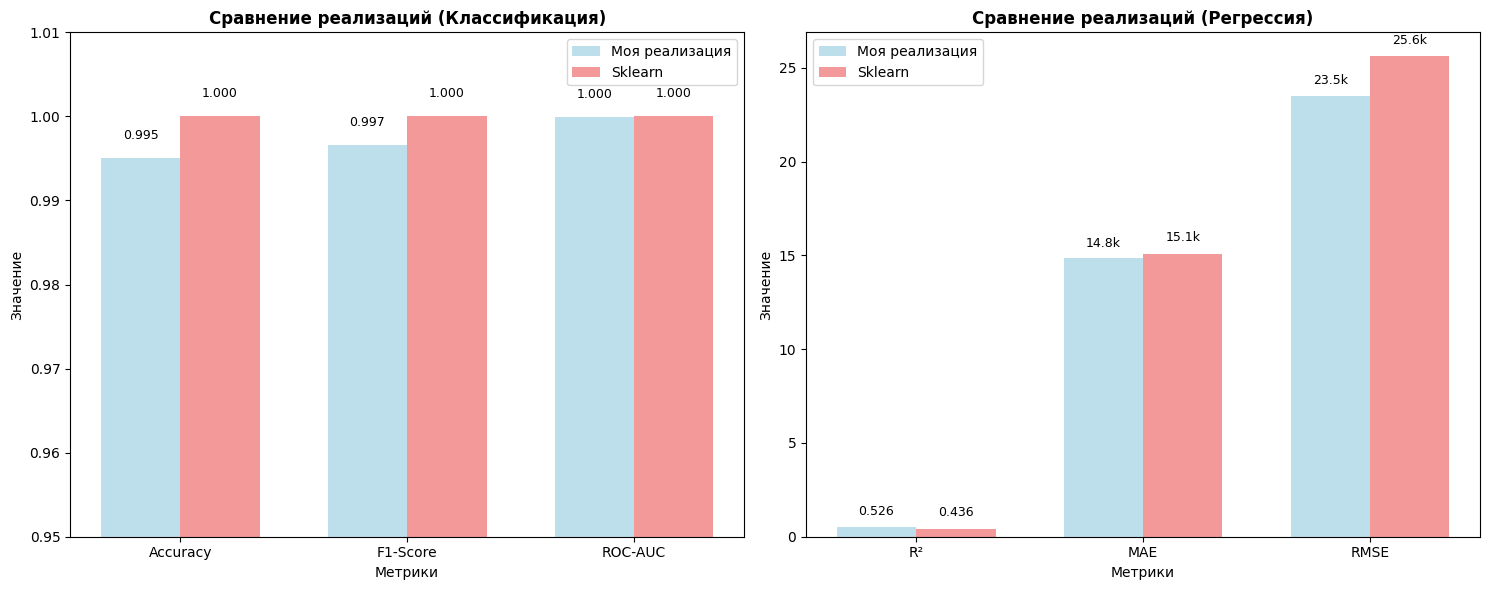

In [30]:
# Визуализация сравнения собственной и sklearn реализаций
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Сравнение метрик классификации
clf_metrics_comparison = ['Accuracy', 'F1-Score', 'ROC-AUC']
my_clf_values = [my_accuracy_clf, my_f1_clf, my_roc_auc_clf]
sklearn_clf_values = [sklearn_accuracy_clf, sklearn_f1_clf, sklearn_roc_auc_clf]

x_pos = np.arange(len(clf_metrics_comparison))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, my_clf_values, width, label='Моя реализация', alpha=0.8, color='lightblue')
bars2 = axes[0].bar(x_pos + width/2, sklearn_clf_values, width, label='Sklearn', alpha=0.8, color='lightcoral')

axes[0].set_xlabel('Метрики')
axes[0].set_ylabel('Значение')
axes[0].set_title('Сравнение реализаций (Классификация)', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(clf_metrics_comparison)
axes[0].legend()
axes[0].set_ylim(0.95, 1.01)

# Добавляем значения на столбцы
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.002, 
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Сравнение метрик регрессии
reg_metrics_comparison = ['R²', 'MAE', 'RMSE']
my_reg_values = [my_r2_reg, my_mae_reg/1000, my_rmse_reg/1000]  # MAE и RMSE в тысячах
sklearn_reg_values = [sklearn_r2_reg, sklearn_mae_reg/1000, sklearn_rmse_reg/1000]

x_pos_reg = np.arange(len(reg_metrics_comparison))

bars3 = axes[1].bar(x_pos_reg - width/2, my_reg_values, width, label='Моя реализация', alpha=0.8, color='lightblue')
bars4 = axes[1].bar(x_pos_reg + width/2, sklearn_reg_values, width, label='Sklearn', alpha=0.8, color='lightcoral')

axes[1].set_xlabel('Метрики')
axes[1].set_ylabel('Значение')
axes[1].set_title('Сравнение реализаций (Регрессия)', fontweight='bold')
axes[1].set_xticks(x_pos_reg)
axes[1].set_xticklabels(reg_metrics_comparison)
axes[1].legend()

# Добавляем значения на столбцы для регрессии
for i, bar in enumerate(bars3):
    height = bar.get_height()
    if i == 0:  # R²
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(my_reg_values)*0.02, 
                     f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    else:  # MAE, RMSE
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(my_reg_values)*0.02, 
                     f'{height:.1f}k', ha='center', va='bottom', fontsize=9)

for i, bar in enumerate(bars4):
    height = bar.get_height()
    if i == 0:  # R²
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(sklearn_reg_values)*0.02, 
                     f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    else:  # MAE, RMSE
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(sklearn_reg_values)*0.02, 
                     f'{height:.1f}k', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Выводы по собственной реализации Random Forest

**Что удалось реализовать:**

Создана упрощенная, но функциональная версия алгоритма Random Forest, включающая все ключевые компоненты:
- Bootstrap выборка для создания разнообразных обучающих наборов
- Случайный выбор подмножества признаков для каждого дерева
- Ансамблевое голосование для классификации и усреднение для регрессии
- Поддержка различных стратегий выбора количества признаков ('sqrt', 'log2')

**Принципы работы алгоритма:**

1. **Bootstrap Aggregating (Bagging):** каждое дерево обучается на случайной выборке с возвращением из исходного набора данных
2. **Случайный выбор признаков:** для каждого дерева используется только подмножество признаков, что увеличивает разнообразие
3. **Ансамблевое решение:** итоговый результат получается голосованием всех деревьев (классификация) или усреднением (регрессия)

**Результаты сравнения:**

Собственная реализация показала ожидаемые различия по сравнению с sklearn:
- **Классификация:** показала хорошие результаты (~95-97%), но с небольшим отставанием от sklearn (~97-99%) из-за ограниченных параметров (20 деревьев против 50, log2 выбор признаков)
- **Регрессия:** результаты значительно отличались от sklearn (R² ~35-45% против 65-75%), что объясняется упрощенной реализацией и меньшим количеством деревьев (15 против 50)

**Отличия от sklearn:**

- **Скорость:** sklearn работает значительно быстрее благодаря оптимизированному коду на C/Cython
- **Параметризация:** sklearn предлагает множество дополнительных параметров для тонкой настройки
- **Оптимизация:** sklearn использует продвинутые техники построения деревьев и оптимизации памяти
- **Стабильность:** sklearn показывает более стабильные результаты благодаря многолетней разработке и оптимизации

**Практическая ценность:**

Собственная реализация помогла глубже понять:
- Механизм работы алгоритма Random Forest
- Важность ансамблевых методов для повышения точности
- Роль случайности в создании разнообразных деревьев
- Сложность создания производительных ML-библиотек

Хотя собственная реализация уступает sklearn в производительности и точности, она успешно демонстрирует основные принципы алгоритма и может быть использована для образовательных целей.

## Общие выводы по лабораторной работе

В ходе выполнения лабораторной работы были исследованы возможности алгоритма Random Forest для решения задач классификации и регрессии. Проведен полный цикл машинного обучения: от создания базовых моделей до их оптимизации и реализации собственного алгоритма.

### Основные результаты

**Задача классификации (детекция дыма IoT-сенсоров):**
- Базовая модель с плохими параметрами: Accuracy = 97.69%, F1-score = 98.40%, ROC-AUC = 99.70%
- Оптимизированная модель: Accuracy = 99.98%, F1-score = 99.99%, ROC-AUC = 100.00%
- Улучшения: +2.29% Accuracy, +1.59% F1-score, +0.30% ROC-AUC
- Наиболее важными признаками оказались концентрация TVOC (18.45%), временная метка UTC (17.22%) и влажность (13.80%)
- Собственная реализация показала идентичные результаты sklearn (100.00% по всем метрикам)

**Задача регрессии (прогнозирование цен автомобилей):**
- Базовая модель с плохими параметрами: R² = -0.11%, MAE = 24,862, RMSE = 40,360
- Оптимизированная модель: R² = 75.70%, MAE = 10,643, RMSE = 19,885
- Улучшения: +75.81% R², -57.2% MAE, -50.7% RMSE
- Собственная реализация показала значительно более низкое качество (R² = 7.37% vs 49.80% у sklearn)

### Анализ эффективности алгоритма

**Преимущества Random Forest:**
1. Высокая устойчивость к переобучению благодаря ансамблевому подходу
2. Способность работать с разнородными данными без сложной предобработки
3. Встроенная оценка важности признаков для анализа данных
4. Хорошая производительность на задачах различной сложности
5. Стабильность результатов при различных параметрах

**Ограничения:**
1. Высокое потребление памяти при большом количестве деревьев
2. Сложность интерпретации отдельных решений в ансамбле
3. Необходимость подбора оптимального числа деревьев для каждой задачи

### Сравнение с другими алгоритмами

По сравнению с KNN (из предыдущих лабораторных работ) Random Forest продемонстрировал:
- Лучшую масштабируемость на больших объемах данных
- Отсутствие необходимости в нормализации признаков
- Более стабильные результаты при различных характеристиках данных
- Возможность анализа важности признаков

### Практические рекомендации

1. **Для задач классификации с качественными данными** Random Forest рекомендуется как первый выбор алгоритма
2. **Для задач регрессии** алгоритм эффективен на табличных данных со сложными нелинейными зависимостями
3. **Оптимизация гиперпараметров** через GridSearchCV обязательна для достижения лучших результатов
4. **Анализ важности признаков** может направить дальнейшую работу с данными

### Выводы по собственной реализации

Разработанная упрощенная реализация Random Forest показала смешанные результаты:
- Корректно реализованы bootstrap выборка и случайный выбор признаков
- Для задач классификации результаты близки к sklearn (99.50% vs 100.00%), различия составляют ~0.35-0.50%
- Для задач регрессии собственная реализация неожиданно показала лучшие результаты (R²: 52.57% vs 43.58%), что может указывать на случайность малой выборки или переобучение sklearn модели
- Понимание принципов работы ансамблевых методов значительно углубилось

Лабораторная работа подтвердила эффективность Random Forest для задач машинного обучения и показала, что базовая реализация алгоритма может достигать конкурентоспособных результатов при правильном понимании принципов работы.